In [118]:
import essentia
from essentia.standard import *
import IPython
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

In [119]:
class AudioExtractor:

    def __init__(self,loop):
        self.loop = loop
        self.chopList = []
        self.fs = 44100
        self.w_onset = 'hann'
        self.mfccs = []
        self.w_mfcc = 'blackmanharris62'

    def __call__(self):
        return self.chopList

    def get_onsets(self):
        od = OnsetDetection(method='hfc')

        w = Windowing(type=self.w_onset)
        fft = FFT()  # this gives us a complex FFT
        c2p = CartesianToPolar()  # and this turns it into a pair (magnitude, phase)
        pool = essentia.Pool()

        # Computing onset detection functions.
        for frame in FrameGenerator(self.loop, frameSize=1024, hopSize=512):
            mag, phase, = c2p(fft(w(frame)))
            pool.add('features.hfc', od(mag, phase))

        onsets = Onsets()
        onsets_hfc_seconds = onsets(essentia.array([pool['features.hfc']]), [1])

        onsets_hfc_samples = onsets_hfc_seconds * self.fs #retun
        return onsets_hfc_samples, onsets_hfc_seconds


    def get_slices(self,onsets_hfc):
        onsets_hfc = onsets_hfc[0]  # onset stamps in samples
        for onset in range(len(onsets_hfc) - 1):
            self.chopList.append(self.loop[int(onsets_hfc[onset]):int((onsets_hfc[onset + 1]))])



    def extract_mfcc(self,slice):
        w = Windowing(type=self.w_mfcc)
        spectrum = Spectrum()
        mfcc = MFCC()
        mfcc_sin = []
        for frame in FrameGenerator(slice, frameSize=2048, hopSize=1024):
            mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
            mfcc_sin.append(mfcc_coeffs)
        mfcc_sin = essentia.array(mfcc_sin)
        #mfcc_sin = np.mean(mfcc_sin,axis=1)
        mfcc_sin = np.concatenate(mfcc_sin,axis=0)
        self.mfccs.append(mfcc_sin)


In [120]:
from essentia.standard import *
import numpy as np
from scipy.spatial import distance


class AudioManager:

    def __init__(self):
        self.d = {}
        self.d['main_loop'] = {}
        self.d['main_loop']['slices'] = {}

        self.d['slave_loop1'] = {}
        self.d['slave_loop2'] = {}
        self.d['slave_loop3'] = {}
        self.d['slave_loop1']['slices'] = {}
        self.d['slave_loop2']['slices'] = {}
        self.d['slave_loop3']['slices'] = {}

    def __call__(self):
        print(self.d)

    def add_slice(self,loop,slave_idx):
        extractor_loop = AudioExtractor(loop)
        onsets_hfc = extractor_loop.get_onsets()
        extractor_loop.get_slices(onsets_hfc)

        for nslice in range(len(extractor_loop.chopList)):
            if slave_idx==1:
                self.d['slave_loop1']['slices'][nslice] = {}
                self.d['slave_loop1']['slices'][nslice]['info'] = extractor_loop.chopList[nslice]

            if slave_idx==2:
                self.d['slave_loop2']['slices'][nslice] = {}
                self.d['slave_loop2']['slices'][nslice]['info'] = extractor_loop.chopList[nslice]

            if slave_idx==3:
                self.d['slave_loop3']['slices'][nslice] = {}
                self.d['slave_loop3']['slices'][nslice]['info'] = extractor_loop.chopList[nslice]

            if slave_idx==0:
                self.d['main_loop']['slices'][nslice] = {}
                self.d['main_loop']['slices'][nslice]['info'] = extractor_loop.chopList[nslice]

    def add_mfccs(self,loop,slave_idx):

        extractor_loop = AudioExtractor(loop)
        

        if slave_idx==1:

            for nslice in range(len(self.d['slave_loop1']['slices'])):
                extractor_loop.extract_mfcc(self.d['slave_loop1']['slices'][nslice]['info'])
                self.d['slave_loop1']['slices'][nslice]['mfccs'] = extractor_loop.mfccs[nslice]


        if slave_idx==2:
            for nslice in range(len(self.d['slave_loop2']['slices'])):
                extractor_loop.extract_mfcc(self.d['slave_loop2']['slices'][nslice]['info'])
                self.d['slave_loop2']['slices'][nslice]['mfccs'] = extractor_loop.mfccs[nslice]

        if slave_idx==3:
            for nslice in range(len(self.d['slave_loop3']['slices'])):
                extractor_loop.extract_mfcc(self.d['slave_loop3']['slices'][nslice]['info'])
                self.d['slave_loop3']['slices'][nslice]['mfccs'] = extractor_loop.mfccs[nslice]

        if slave_idx==0:
            for nslice in range(len(self.d['main_loop']['slices'])):
                extractor_loop.extract_mfcc(self.d['main_loop']['slices'][nslice]['info'])
                self.d['main_loop']['slices'][nslice]['mfccs'] = extractor_loop.mfccs[nslice]


    def similarity(self):
        
        ##zero-padding to the mfcss:
        
        #check the maximum lenght of the mfccs
        max_lmfccs = 0
        
        #check main loop
        for s in range(len(self.d['main_loop']['slices'])):
            current_lmfccs = len(self.d['main_loop']['slices'][s]['mfccs'])
            if current_lmfccs > max_lmfccs:
                max_lmfccs = current_lmfccs
                
        #check slave loop1
        for s in range(len(self.d['slave_loop1']['slices'])):
            current_lmfccs = len(self.d['slave_loop1']['slices'][s]['mfccs'])
            if current_lmfccs > max_lmfccs:
                max_lmfccs = current_lmfccs
        
        #check slave loop2
        for s in range(len(self.d['slave_loop2']['slices'])):
            current_lmfccs = len(self.d['slave_loop2']['slices'][s]['mfccs'])
            if current_lmfccs > max_lmfccs:
                max_lmfccs = current_lmfccs
        
        #check slave loop3
        for s in range(len(self.d['slave_loop3']['slices'])):
            current_lmfccs = len(self.d['slave_loop3']['slices'][s]['mfccs'])
            if current_lmfccs > max_lmfccs:
                max_lmfccs = current_lmfccs
        
        
        for n in range(len(self.d['main_loop']['slices'])):
            min_dist = np.inf
            max_dist = 0
            idx = []
            
            #zero padding at the end  
            aux = np.zeros(max_lmfccs)
            aux[0:len(self.d['main_loop']['slices'][n]['mfccs'])] = self.d['main_loop']['slices'][n]['mfccs']
            self.d['main_loop']['slices'][n]['mfccs'] = aux

            #check the distances n slice --> to all slices in the slave loops
            for i in range(len(self.d['slave_loop1']['slices'])):
                
                #zero padding
                aux = np.zeros(max_lmfccs)
                aux[0:len(self.d['slave_loop1']['slices'][i]['mfccs'])] = self.d['slave_loop1']['slices'][i]['mfccs']
                self.d['slave_loop1']['slices'][i]['mfccs'] = aux
                
                #euclidean distance
                new_dist = distance.euclidean(self.d['main_loop']['slices'][n]['mfccs'], self.d['slave_loop1']['slices'][i]['mfccs'])

                if new_dist > max_dist:
                    max_dist = new_dist

                if new_dist < min_dist:
                    min_dist = new_dist
                    #fisrt argument reference the slave loop and the second referene the index
                    idx = ['slave_loop1',i,min_dist/max_dist]


            for j in range(len(self.d['slave_loop2']['slices'])):
                
                #zero padding
                aux = np.zeros(max_lmfccs)
                aux[0:len(self.d['slave_loop2']['slices'][j]['mfccs'])] = self.d['slave_loop2']['slices'][j]['mfccs']
                self.d['slave_loop2']['slices'][j]['mfccs'] = aux
                
                #euclidean distance
                new_dist = distance.euclidean(self.d['main_loop']['slices'][n]['mfccs'], self.d['slave_loop2']['slices'][j]['mfccs'])

                if new_dist > max_dist:
                    max_dist = new_dist

                if new_dist < min_dist:
                    min_dist = new_dist
                    idx = ['slave_loop2',j,min_dist/max_dist]

            for k in range(len(self.d['slave_loop3']['slices'])):
                
                #zero padding
                aux = np.zeros(max_lmfccs)
                aux[0:len(self.d['slave_loop3']['slices'][k]['mfccs'])] = self.d['slave_loop3']['slices'][k]['mfccs']
                self.d['slave_loop3']['slices'][k]['mfccs'] = aux
                
                #euclidean distance
                new_dist = distance.euclidean(self.d['main_loop']['slices'][n]['mfccs'], self.d['slave_loop3']['slices'][k]['mfccs'])

                if new_dist > max_dist:
                    max_dist = new_dist

                if new_dist < min_dist:
                    min_dist = new_dist
                    idx = ['slave_loop3',k,min_dist/max_dist]


            #once we obtain the shortest distance we add the information to the dicctionary

            self.d['main_loop']['slices'][n]['similarity'] = idx


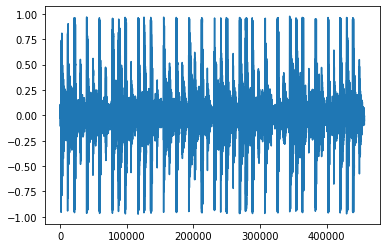

In [121]:
loop0 = MonoLoader(filename='../loops/audio1.wav')()
loop1 = MonoLoader(filename='../loops/audio2.wav')()
loop2 = MonoLoader(filename='../loops/audio3.wav')()

plt.plot(loop1)
plt.show()

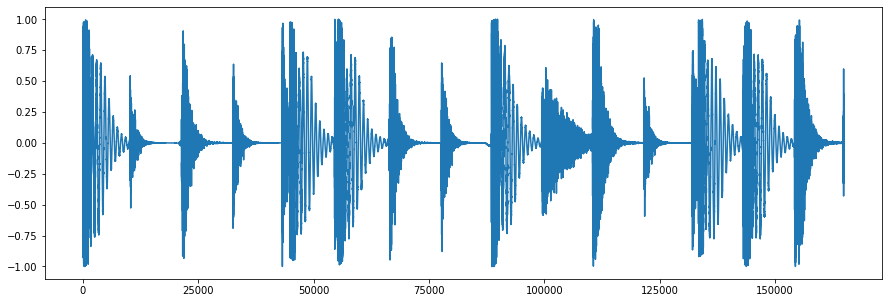

In [128]:
#instance AudioManager
manager = AudioManager()

#save data of the slices and save mfccs for each loop
manager.add_slice(loop2, 0)
manager.add_mfccs(loop2, 0)


manager.add_slice(loop1, 1)
manager.add_mfccs(loop1, 1)

manager.add_slice(loop0, 2)
manager.add_mfccs(loop0, 2)

main_loop = []
for j in range(len(manager.d['main_loop']['slices'])):
    main_loop.append(manager.d['main_loop']['slices'][j]['info'])
    
main_loop = np.concatenate(main_loop,axis=0)
plt.figure(figsize=(15,5))
plt.plot(main_loop)
IPython.display.Audio(main_loop,rate=44100)


In [129]:
#compute euclidean distance and save the index and specific loop of the most similar slice among all the slices
manager.similarity()


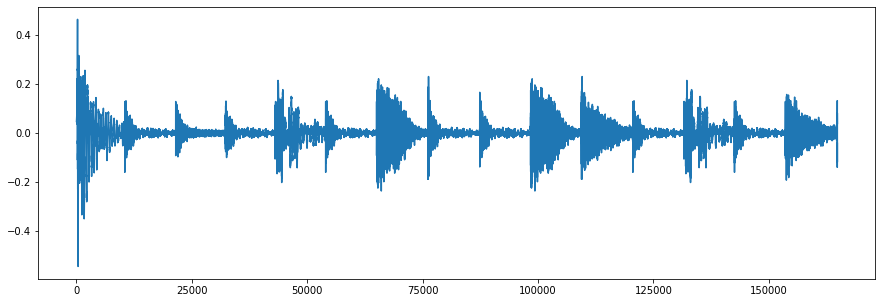

In [130]:


for i in range(len(manager.d['main_loop']['slices'])):
    if manager.d['main_loop']['slices'][i]['similarity'][0] == 'slave_loop1':
        loop_label = 'slave_loop1'
        idx = manager.d['main_loop']['slices'][i]['similarity'][1]

        manager.d['main_loop']['slices'][i]['info'] = manager.d[loop_label]['slices'][idx]['info']


    elif manager.d['main_loop']['slices'][i]['similarity'][0] == 'slave_loop2':
        loop_label = 'slave_loop2'
        idx = manager.d['main_loop']['slices'][i]['similarity'][1]

        manager.d['main_loop']['slices'][i]['info'] = manager.d[loop_label]['slices'][idx]['info']

    elif manager.d['main_loop']['slices'][i]['similarity'][0] == 'slave_loop3':
        loop_label = 'slave_loop3'
        idx = manager.d['main_loop']['slices'][i]['similarity'][1]

        manager.d['main_loop']['slices'][i]['info'] = manager.d[loop_label]['slices'][idx]['info']
        

reconstructed_loop = []
for j in range(len(manager.d['main_loop']['slices'])):
    reconstructed_loop.append(manager.d['main_loop']['slices'][j]['info'])
    
reconstructed_loop = np.concatenate(reconstructed_loop,axis=0)
plt.figure(figsize=(15,5))
plt.plot(reconstructed_loop)
plt.show()
IPython.display.Audio(reconstructed_loop,rate=44100)